# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc._settings.ScanpyConfig.n_jobs = 40

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

CPU times: user 44.5 s, sys: 6.12 s, total: 50.7 s
Wall time: 50.7 s


(1306127, 27998)

In [6]:
# To reduce the number of cells: 
USE_FIRST_N_CELLS = 500000
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(500000, 27998)

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 54.1 s, sys: 11.9 s, total: 1min 5s
Wall time: 1min 5s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 7.53 s, sys: 2.75 s, total: 10.3 s
Wall time: 10.3 s


In [10]:
adata.shape

(496004, 23178)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 2.75 s, sys: 396 ms, total: 3.15 s
Wall time: 3.14 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 7.62 s, sys: 535 µs, total: 7.62 s
Wall time: 7.62 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 5.71 s, sys: 620 ms, total: 6.33 s
Wall time: 6.32 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

CPU times: user 5.43 s, sys: 228 ms, total: 5.66 s
Wall time: 5.66 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 4min 35s, sys: 4min 23s, total: 8min 59s
Wall time: 9min 29s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 6.31 s, sys: 703 ms, total: 7.02 s
Wall time: 7.02 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 675.4260559082031


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 3h 27min 20s, sys: 33min 54s, total: 4h 1min 14s
Wall time: 2min 1s


### TSNE + K-means

In [ ]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, use_fast_tsne=True)

#12min 18s

In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 52min 3s, sys: 1h 50min 45s, total: 2h 42min 48s
Wall time: 1min 17s


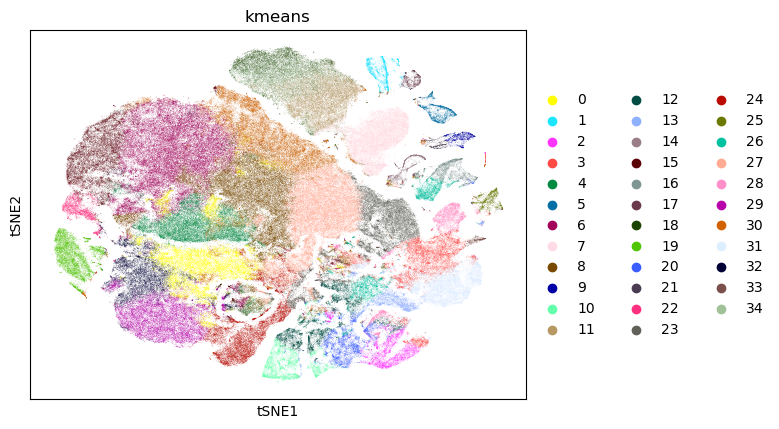

CPU times: user 1.63 s, sys: 180 ms, total: 1.81 s
Wall time: 1.61 s


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

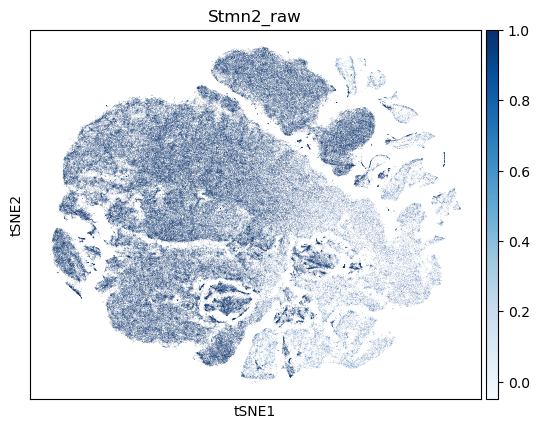

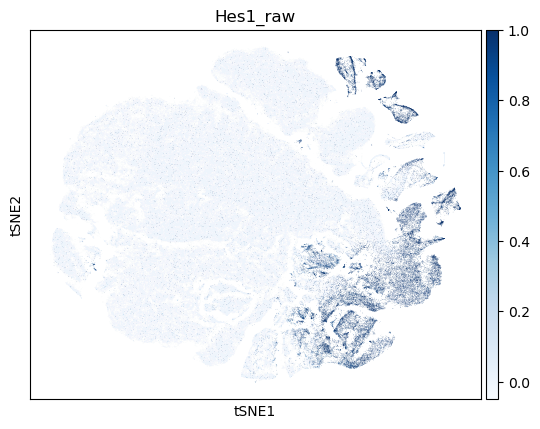

CPU times: user 1.91 s, sys: 316 ms, total: 2.22 s
Wall time: 1.82 s


In [22]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 9min 14s, sys: 10min 58s, total: 20min 12s
Wall time: 56.8 s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 5h 11min 49s, sys: 1h 46min 14s, total: 6h 58min 4s
Wall time: 6min 15s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 2min 43s, sys: 1.36 s, total: 2min 45s
Wall time: 2min 43s


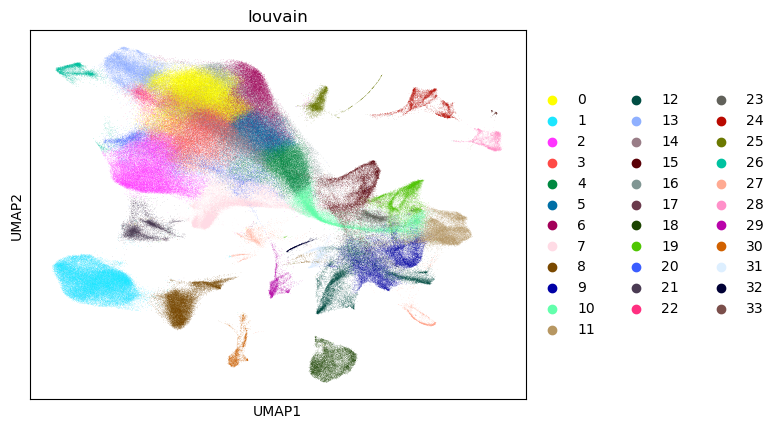

CPU times: user 1.53 s, sys: 191 ms, total: 1.72 s
Wall time: 1.52 s


In [26]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [27]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 7min 19s, sys: 12.9 s, total: 7min 32s
Wall time: 7min 30s


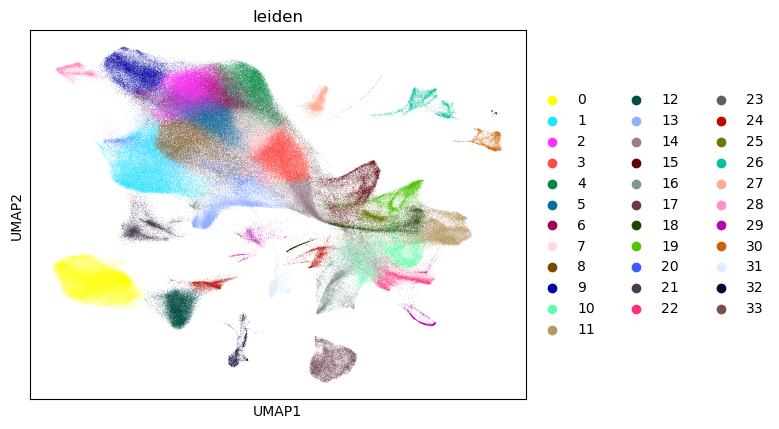

CPU times: user 1.56 s, sys: 165 ms, total: 1.73 s
Wall time: 1.53 s


In [28]:
%%time
sc.pl.umap(adata, color=["leiden"])

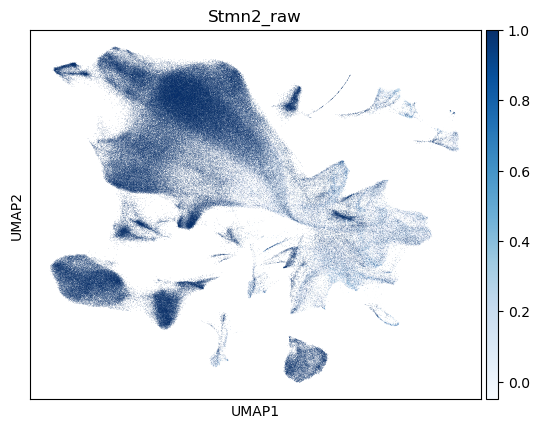

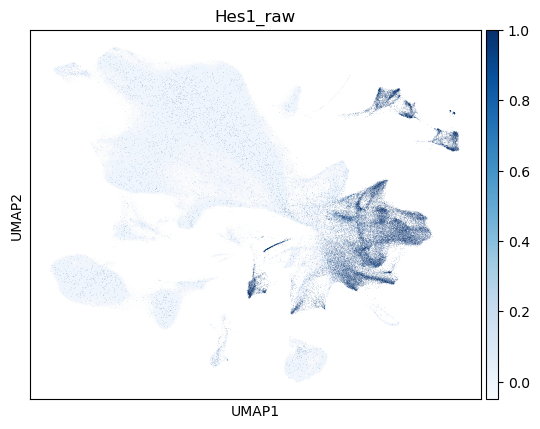

CPU times: user 1.82 s, sys: 332 ms, total: 2.15 s
Wall time: 1.75 s


In [29]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Differential expression analysis

In [30]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=50, groups='all', reference='rest', method='logreg')

CPU times: user 1d 2h 2min 45s, sys: 23h 28min 47s, total: 2d 1h 31min 33s
Wall time: 24min 4s


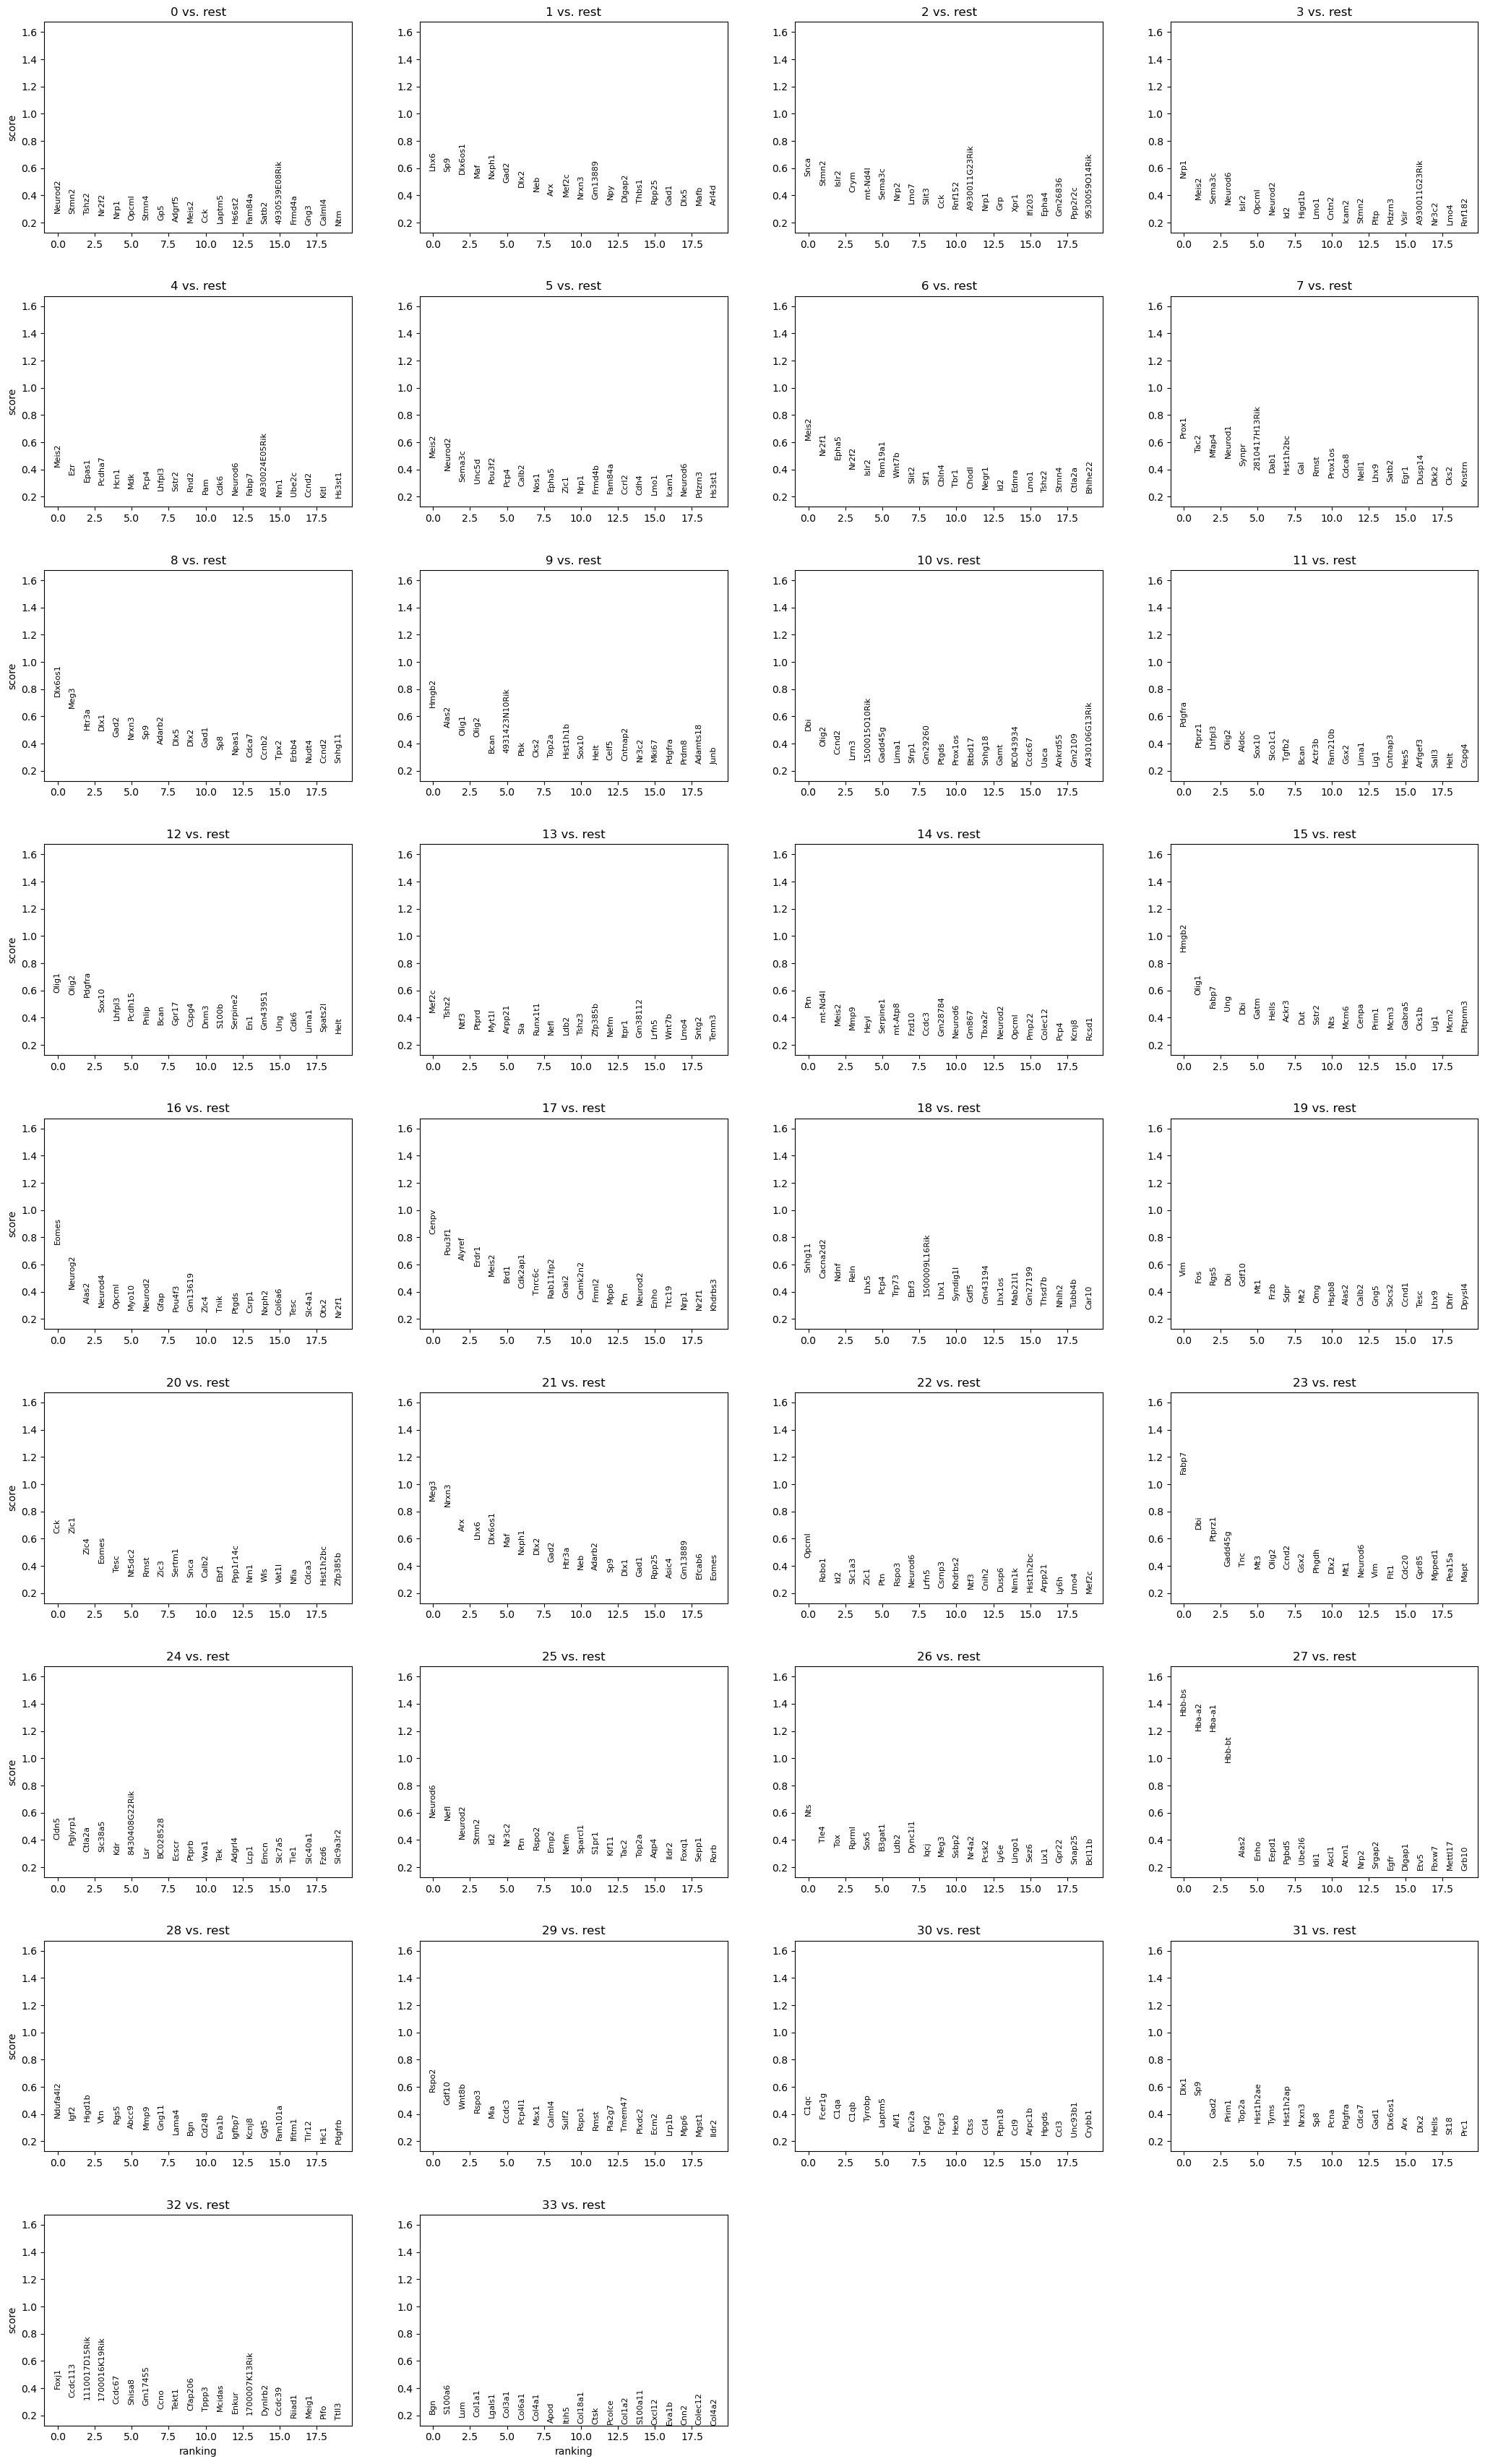

CPU times: user 4.6 s, sys: 3.44 s, total: 8.04 s
Wall time: 3.45 s


In [31]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [32]:
reanalysis_start = time.time()

In [33]:
%%time
hes1_cells = adata.obs["Hes1_raw"] > 0.0
adata = adata[hes1_cells,:]
adata.shape

CPU times: user 9.3 ms, sys: 829 µs, total: 10.1 ms
Wall time: 9.91 ms


(51073, 4000)

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

In [34]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 43min 13s, sys: 11min 34s, total: 54min 48s
Wall time: 52.9 s


And plot the results:

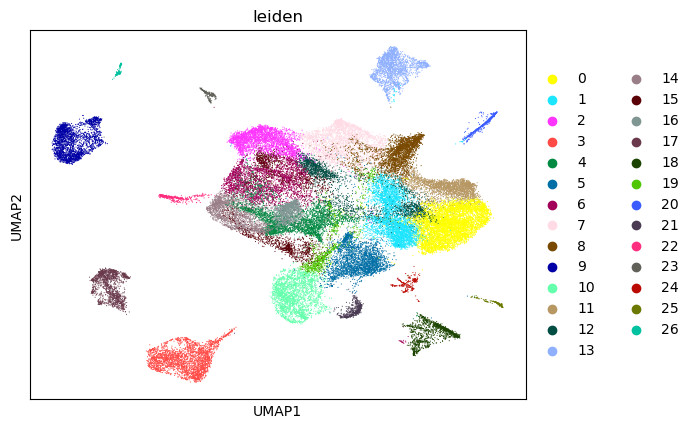

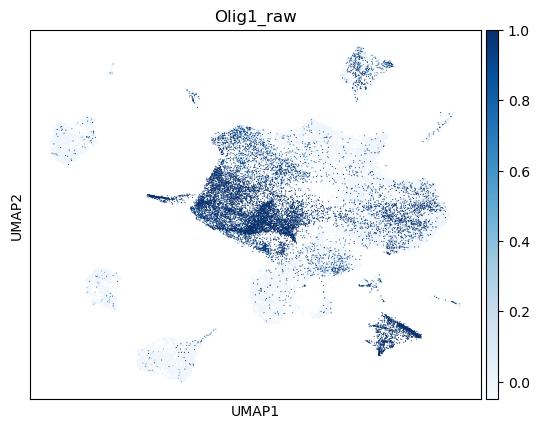

CPU times: user 853 ms, sys: 350 ms, total: 1.2 s
Wall time: 802 ms


In [35]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [36]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 53.73904037475586


In [38]:
print("Full time: %s" % (time.time() - start))

Full time: 4430.6828463077545
